# Exogenous Regressors

> How to include exogenous regressors.

With `StatsForecast` you can easily include exogenous regressors. Some methods, such as `AutoARIMA`, have the ability to include exogenous regressors, while other models only use the time series information. `StatsForecast` takes care of passing the exogenous variables to the models that use them. 

## Install statsforecast

In [ ]:
%%capture
!pip install statsforecast

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF as Y_df

In this example, we will use the `AirPassengers` dataset to show how to work with exogenous regressors.

In [ ]:
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## Split train/test sets

We will use the last `12` observations of the dataset as the test set.

In [ ]:
horizon = 12
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

## Add exogenous regressors

In this example, we will include the `trend` as exogenous regressor. But you can include as many as you have or want.

In [ ]:
%%capture
Y_train_df['trend'] = np.arange(1, len(Y_train_df) + 1)

In [ ]:
Y_train_df.head()

,unique_id,ds,y,trend
0,1.0,1949-01-31,112.0,1
1,1.0,1949-02-28,118.0,2
2,1.0,1949-03-31,132.0,3
3,1.0,1949-04-30,129.0,4
4,1.0,1949-05-31,121.0,5


In [ ]:
Y_train_df.tail()

,unique_id,ds,y,trend
127,1.0,1959-08-31,559.0,128
128,1.0,1959-09-30,463.0,129
129,1.0,1959-10-31,407.0,130
130,1.0,1959-11-30,362.0,131
131,1.0,1959-12-31,405.0,132


Observe that the exogenous regressors have to be placed after the target variable `y`.

### Create future exogenous regressors

In order for the model to produce forecasts, it needs the future exogenous regressors. In this section we will construct a dataframe that includes the future `trend`.

In [ ]:
X_test_df = pd.DataFrame({
  'unique_id': 1.0,
  'ds': pd.date_range(start='1960-01-01', periods=horizon, freq='M')
})
# We construct xreg for test. The train series ends at the 133th step. 
X_test_df['trend'] = np.arange(133, 133 + horizon)
X_test_df.head()

,unique_id,ds,trend
0,1.0,1960-01-31,133
1,1.0,1960-02-29,134
2,1.0,1960-03-31,135
3,1.0,1960-04-30,136
4,1.0,1960-05-31,137


## Train the model

In [ ]:
season_length = 12
model = StatsForecast(
    df=Y_train_df, 
    models=[AutoARIMA(season_length=12)], 
    freq='M', 
    n_jobs=-1
)

### Forecast mode

The `StatsForecast.forecast` method is more computationally efficient since it does not save objects during training and predicting. The method receives the future exogenous regressors `X_test_df`. 

In [ ]:
Y_hat_df = model.forecast(horizon, X_df=X_test_df)
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,AutoARIMA
0,1.0,1960-01-31,414.551483
1,1.0,1960-02-29,387.550842
2,1.0,1960-03-31,445.526978
3,1.0,1960-04-30,431.495422
4,1.0,1960-05-31,452.797211


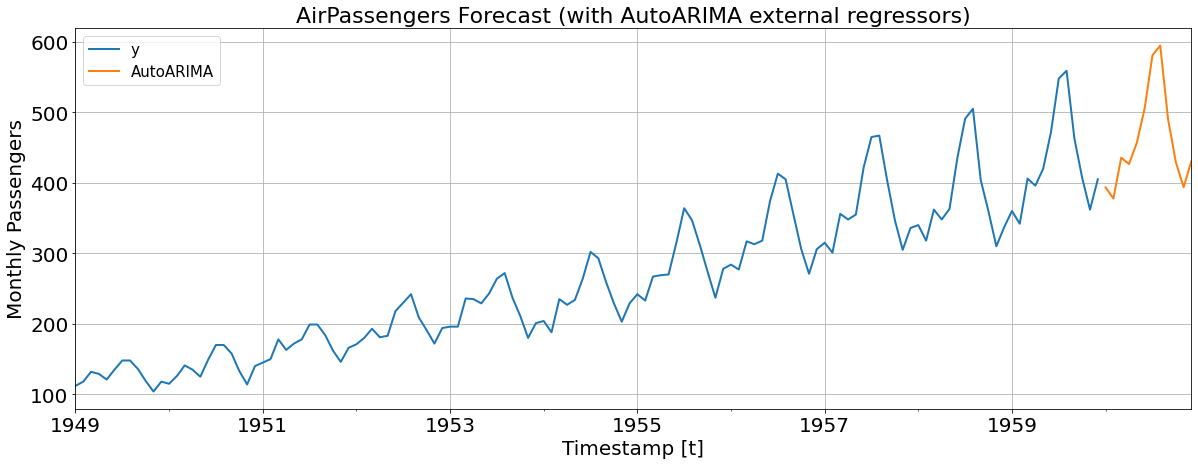

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
df_plot = pd.concat([Y_train_df, Y_hat_df_xreg]).set_index('ds')
df_plot[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast (with AutoARIMA external regressors)', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

### SKlearn syntax

The `sklearn` syntax can also be used. Fist, train the model using the `StatsForecast.fit` method.

In [ ]:
model.fit()

StatsForecast(models=[AutoARIMA])

The use the fitted model to produce forecasts. Observe that the `StatsForecast.predict` method receives the future exogenous regressors.

In [ ]:
model.predict(horizon, X_df=X_test_df)

,ds,AutoARIMA
unique_id,,
1.0,1960-01-31,414.551483
1.0,1960-02-29,387.550842
1.0,1960-03-31,445.526978
1.0,1960-04-30,431.495422
1.0,1960-05-31,452.797211
1.0,1960-06-30,502.991394
1.0,1960-07-31,577.782837
1.0,1960-08-31,587.973938
1.0,1960-09-30,491.432617


## Including prediction intervals

You can also compute prediction intervals using exogenous regressors. Simply add the `level` argument.

### Forecast mode

In [ ]:
Y_hat_df = model.forecast(horizon, X_df=X_test_df, level=(80,95))
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
0,1.0,1960-01-31,414.551483,393.468414,400.765991,428.337006,435.634583
1,1.0,1960-02-29,387.550842,362.181641,370.962830,404.138855,412.920044
2,1.0,1960-03-31,445.526978,418.457153,427.826965,463.226990,472.596832
3,1.0,1960-04-30,431.495422,403.697540,413.319366,449.671478,459.293304
4,1.0,1960-05-31,452.797211,424.679352,434.411926,471.182495,480.915070


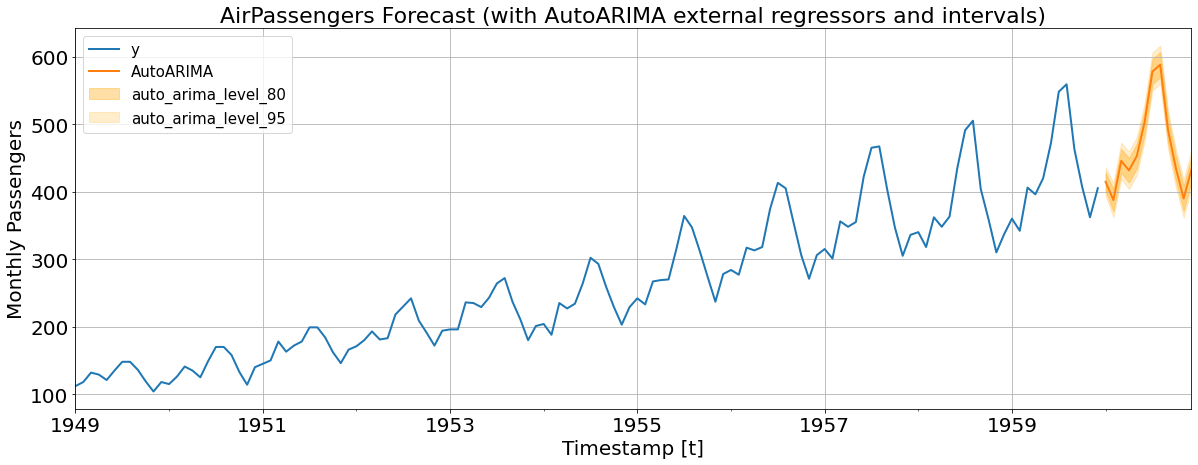

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
df_plot[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-80'], 
                df_plot['AutoARIMA-hi-80'],
                alpha=.35,
                color='orange',
                label='auto_arima_level_80')
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='orange',
                label='auto_arima_level_95')
ax.set_title('AirPassengers Forecast (with AutoARIMA external regressors and intervals)', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

### SKlearn syntax

Since the model is already fitted, just add `level=(80,90)` to the `StatsForecast.predict` method.

In [ ]:
model.predict(horizon, X_df=X_test_df, level=(80, 90))

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90
unique_id,,,,,,
1.0,1960-01-31,414.551483,396.858002,400.765991,428.337006,432.244995
1.0,1960-02-29,387.550842,366.260345,370.962830,404.138855,408.841339
1.0,1960-03-31,445.526978,422.809265,427.826965,463.226990,468.244720
1.0,1960-04-30,431.495422,408.166718,413.319366,449.671478,454.824127
1.0,1960-05-31,452.797211,429.199951,434.411926,471.182495,476.394470
1.0,1960-06-30,502.991394,479.274841,484.513153,521.469604,526.707947
1.0,1960-07-31,577.782837,554.013000,559.263123,596.302551,601.552612
1.0,1960-08-31,587.973938,564.180298,569.435669,606.512207,611.767517
1.0,1960-09-30,491.432617,467.628357,472.886047,509.979187,515.236877
